This notebook uses Multivariate Linear Regression (MVLR) from scikit-learn to set a baseline in terms of accuracy for the other models.

# Imports

`TODO: Remove unnecessary imports`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from livelossplot import PlotLossesKeras

from keijzer import *


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Setup (multi) GPU usage with scalable VRAM
num_gpu = setup_multi_gpus()

Amount of GPUs available: 1


# Load the data

In [3]:
%pwd

'F:\\Jupyterlab\\Multivariate-time-series-models-in-Keras\\notebooks'

In [4]:
path = _
path = path[:-10] # removes '\\notebooks' from the path string

df = pd.read_csv(path+"\\data\\house_data_processed.csv", delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime']) 

magnitude = 1 # Take this from the 1. EDA & Feauture engineering notebook. It's the factor where gasPower has been scaled with to the power 10.

In [5]:
df.head()

,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,
2017-02-28 12:00:00,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1


# Preprocessing
Prepare the data for the used model.

In [6]:
data = df.copy()

## Datetime info to categorical
Certain functions are able to use the Pandas categorical datatype, e.g. they don't require the feautures to be one-hot encoded.  

In [7]:
columns_to_category = ['hour', 'dayofweek', 'season']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

# One hot encoding // dummy variables
One hot encode the categorical feautures.

In [8]:
data = pd.get_dummies(data, columns=columns_to_category) # One hot encoding the categories
data.head()

,FF,RG,T,gasPower,gasPower_std,hour_0,hour_1,hour_2,hour_3,hour_4,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 12:00:00,9.067500,0.0,5.183333,6.115723,0.085626,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 13:00:00,8.684999,0.0,5.300000,5.238647,0.318250,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 14:00:00,8.296667,0.0,5.283333,2.451172,0.041087,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 15:00:00,6.918334,0.0,5.516667,3.065186,0.214238,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2017-02-28 16:00:00,6.583333,0.0,5.433333,8.120117,0.014156,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


# Create a train & test set
The original DataFrame will be sliced up into a train and test set.  
See the plot below for clarification.  
The test set is used for the model cross-validation, decisions about the architecture and hyperparameters should not be made based on the test set.

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop(['gasPower'], axis=1)
#print('X columns: %s' % list(X.columns))

y = data['gasPower']

#X = np.array(X).reshape(-1,len(X.columns)) # Reshape to required dimensions for sklearn
#y = np.array(y).reshape(-1,1)

train_size = 0.7

split_index = int(data.shape[0]*train_size) # the index at which to split df into train and test

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

# Visualization of the train & test set target values

## The complete dataset

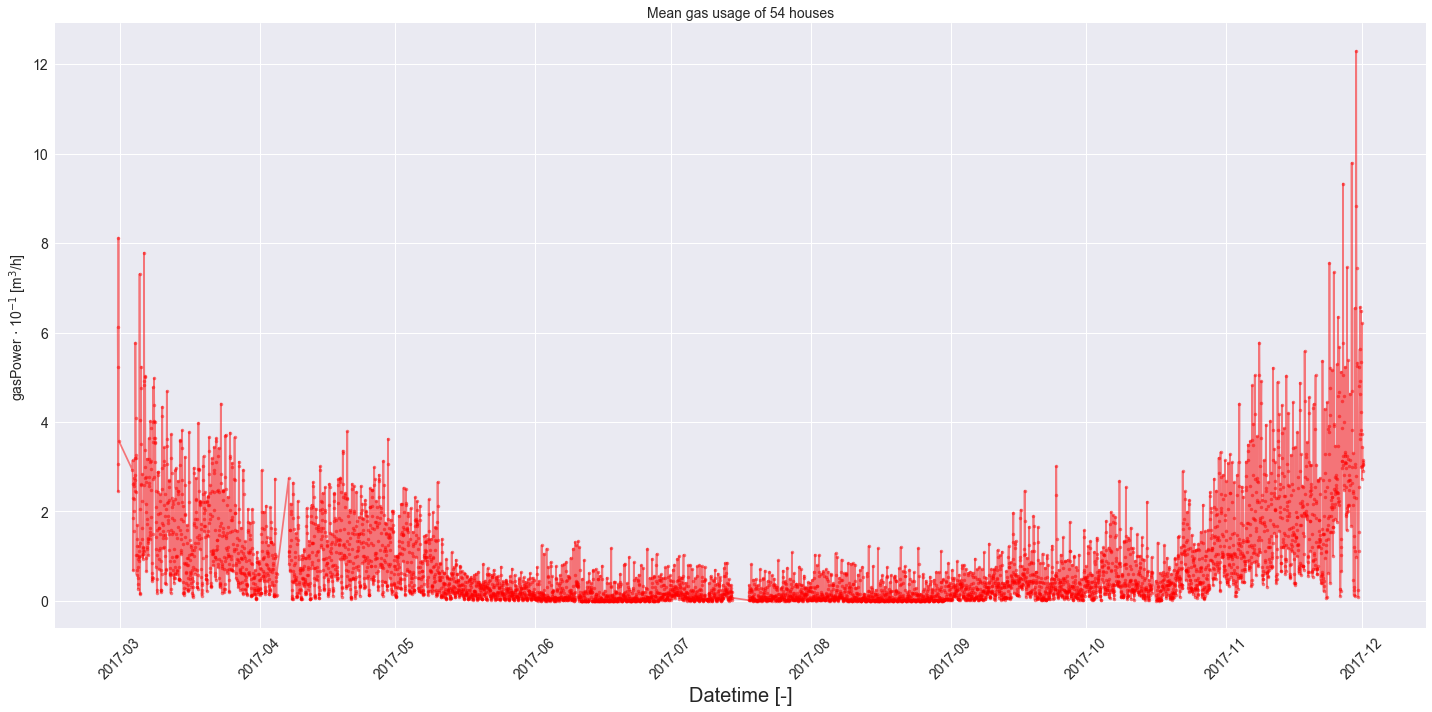

In [10]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.title('Mean gas usage of 52 houses', fontsize=14)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

## The train & test set

Get the `X_train` and `X_test` datetime values.  

In [11]:
split_index = int(data.shape[0]*train_size)

X_train_values = data[:split_index] # get the datetime values of X_train
X_test_values = data[split_index:] # get the datetime values of X_train

Create the plot.

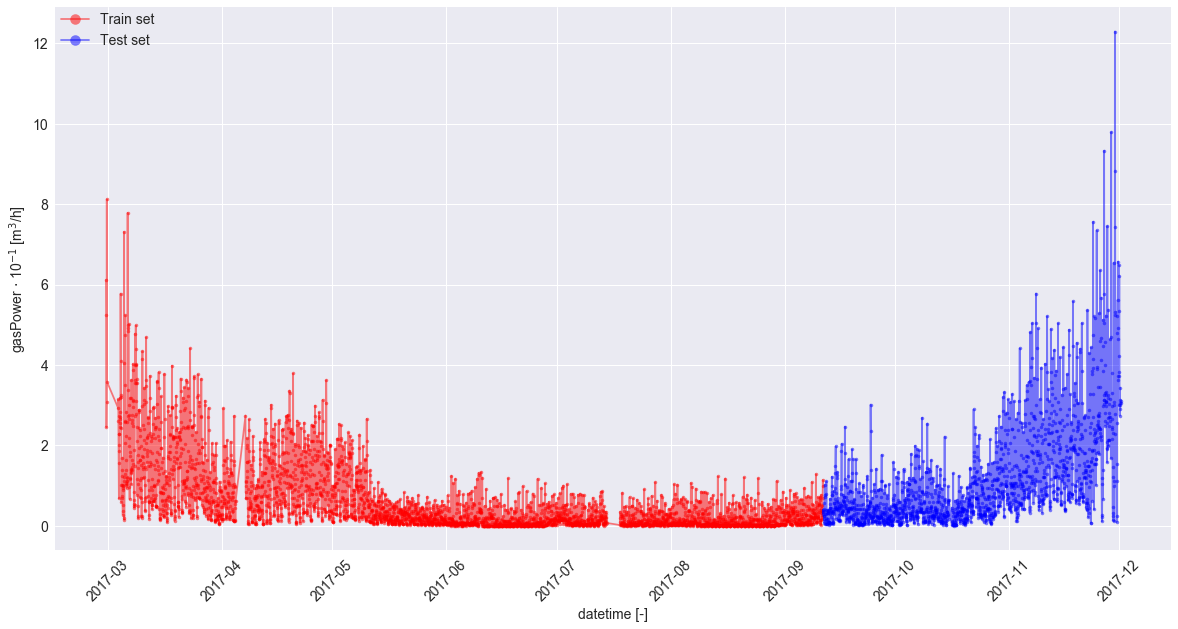

In [12]:
plt.figure(figsize=(20,10))

plt.plot(X_train_values.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test_values.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

# Feature scaling
First fit the `StandardScaler()` to `X_train`.  
Then transform `X_train` and `X_test`, this way there is no data leakage from the `X_test` dataset.  
Note that the target $y$ does not need to be scaled.  
Feautures are scaled because they're an input to the neural network (NN), literature about this can be found online.  
Basically the NN converges best when the inputs are on the same scale from around -1 to 1.  

In [13]:
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)

X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

print((X_train.shape, y_train.shape))

print((X_test.shape, y_test.shape))

((4446, 39), (4446,))
((1906, 39), (1906,))


# MVLR model

Multivariate Linear Regression

In [14]:
%%time

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

Wall time: 232 ms


# Cross validate on the test set

In [15]:
y_pred = model.predict(X_test)
y_true = y_test.values.reshape(y_test.shape[0], 1)

split_index = int(data.shape[0]*train_size)
x = data[split_index:]

datetime_difference = len(x) - len(y_true)

FINISHED


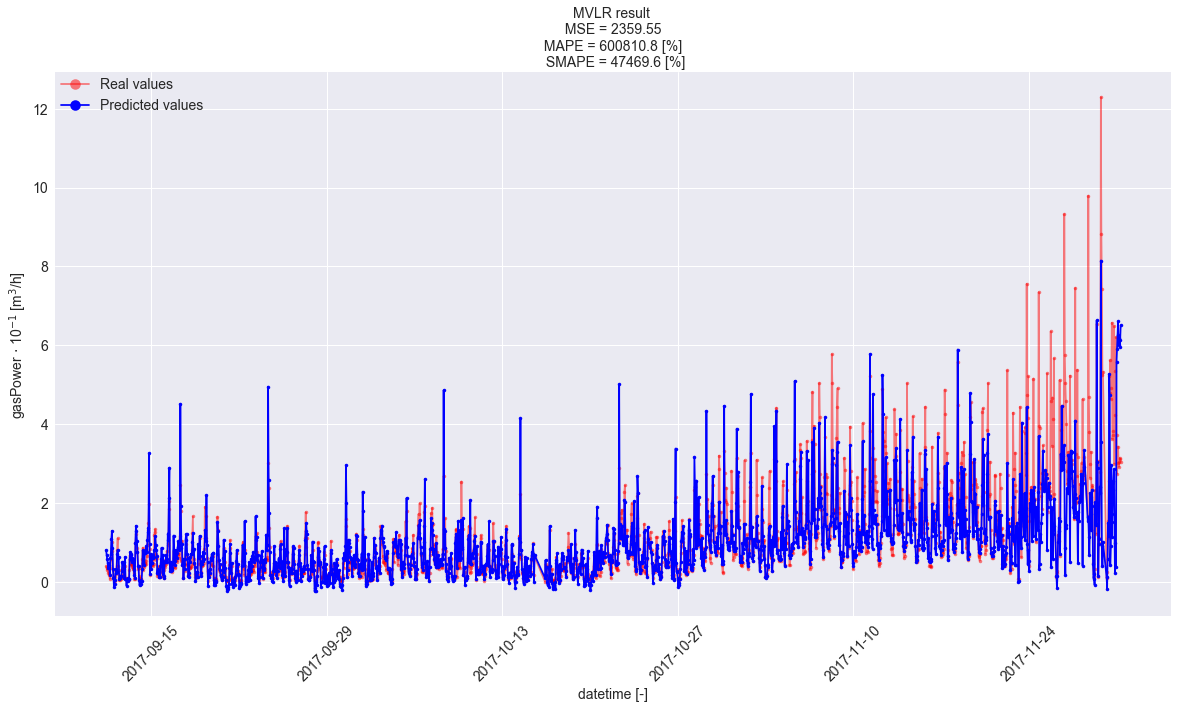

In [16]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=1)

plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude, fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

n = len(y_pred) + len(y_true)

# Recalculated the metrics for the downsampled results
mse_result = (1/n)*np.sum((y_pred - y_true)**2)
mape_result = (100/n) * np.sum(np.abs((y_true - y_pred) / y_pred))
smape_result = (100/n) * np.sum( np.abs((y_true - y_pred)) / (np.abs(y_true) + np.abs(y_pred)) )

plt.title('MVLR result \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse_result, mape_result, smape_result), fontsize = 14)

#plt.savefig('figures/MVLR_hour.png', dpi=1200)
print('FINISHED')

# Downsample the hourly prediction
The `downsample_results()` function from `keijzer.py` downsamples the hourly predictions to the given resolution using `pd.DataFrame.resample(resolution).sum()` and then plots the result.

# Hour

(1906,)


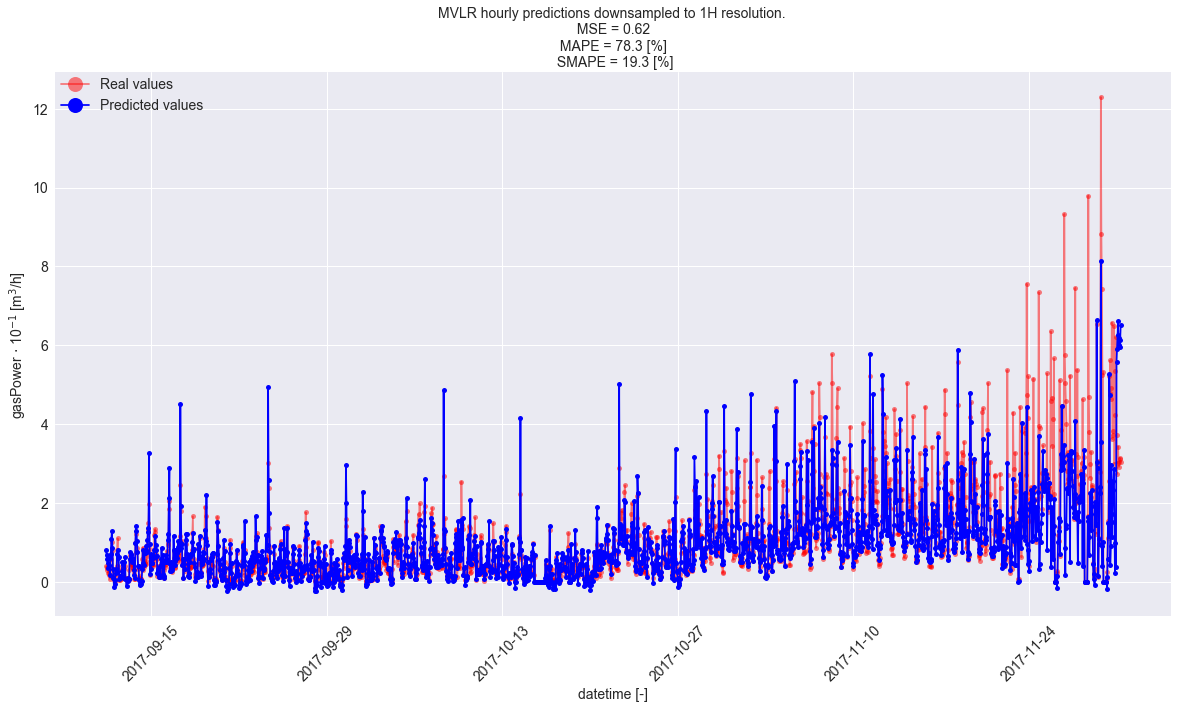

In [17]:
# It is a problem that resampling to the original samplerate gives different metrics...
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='1H', model_name='MVLR', savefig=False)

# Day

(1906,)


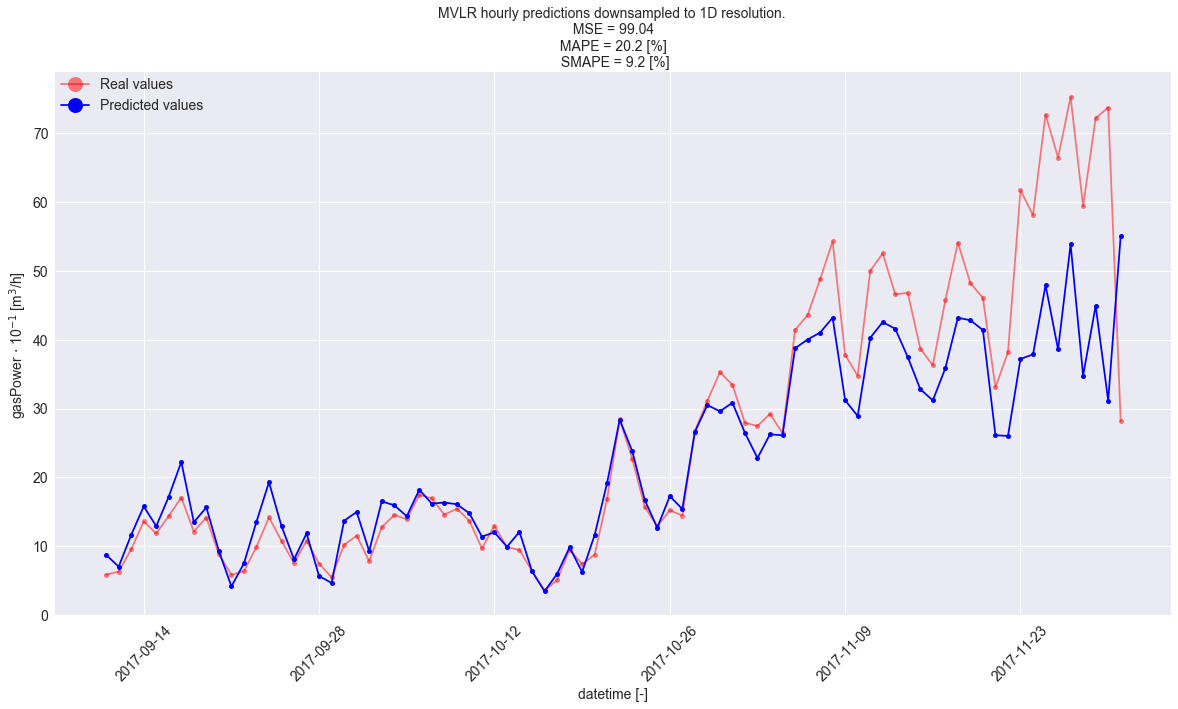

In [18]:
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='1D', model_name='MVLR', savefig=False)

# Week

(1906,)


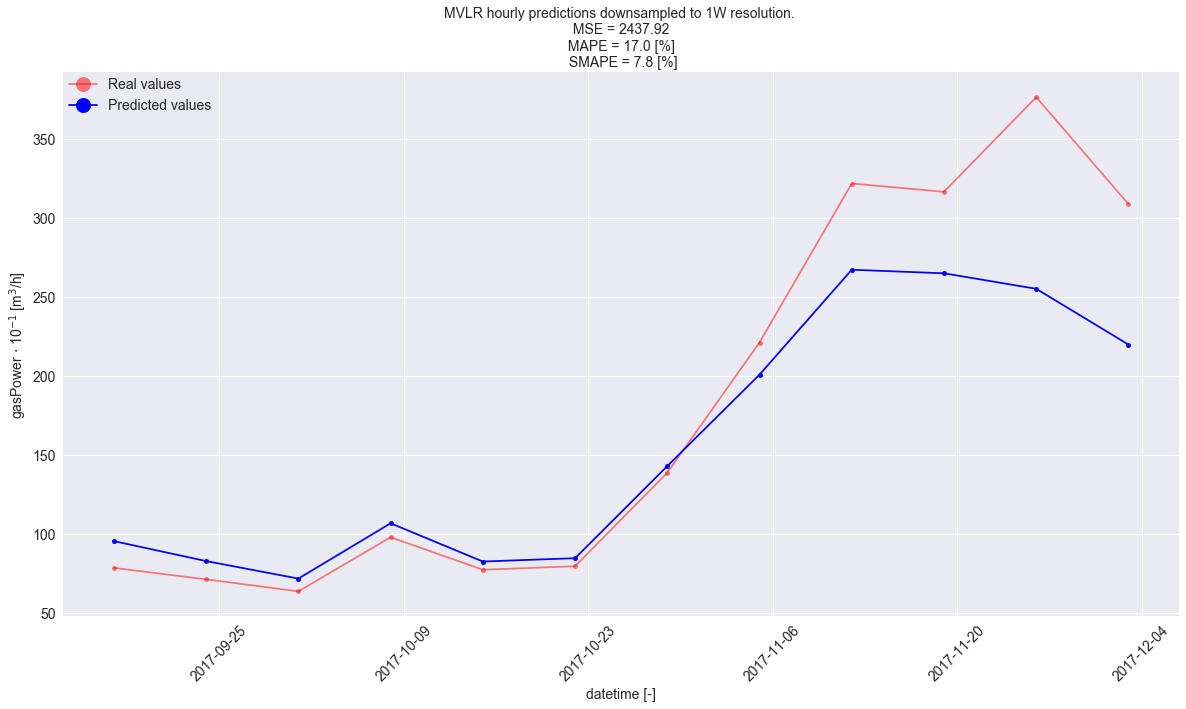

In [19]:
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='1W', model_name='MVLR', savefig=False)

# 4 Weeks

(1906,)


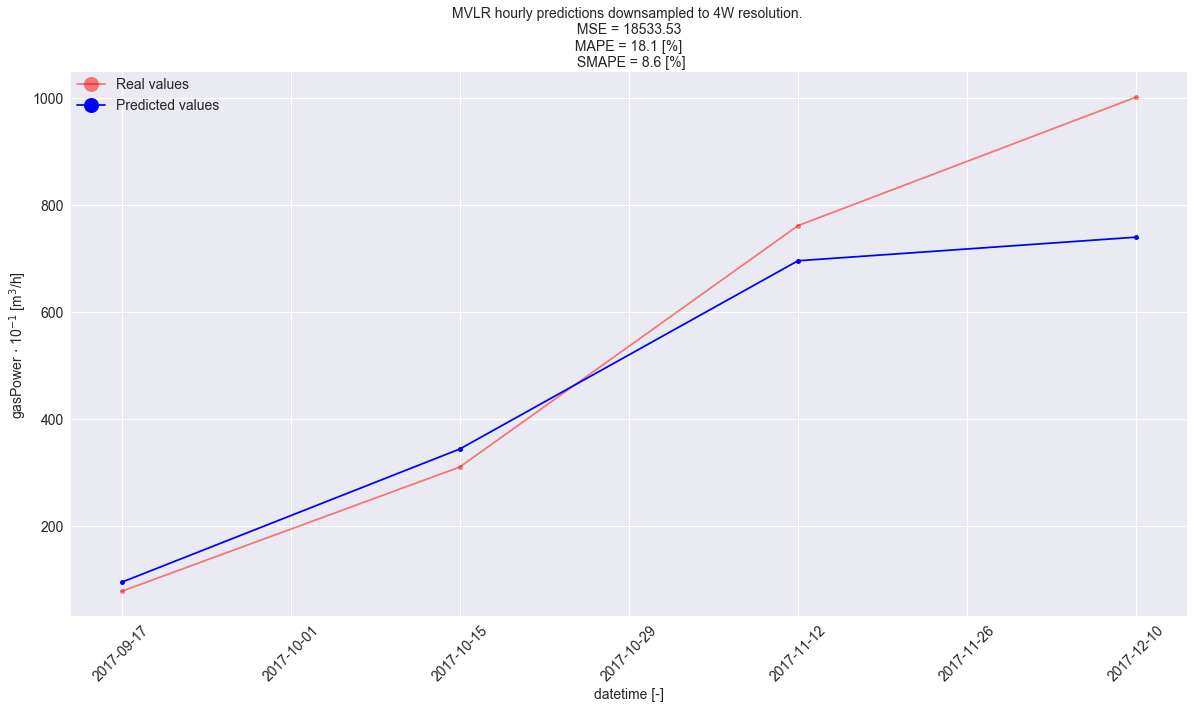

In [20]:
downsample_results(x, y_pred, y_true, magnitude=magnitude, resolution='4W', model_name='MVLR', savefig=False)